In [1]:
%matplotlib inline
import random
import time
from datetime import datetime
import matplotlib.pyplot as plt
import asyncio
import nest_asyncio

We use `asyncio`, as opposed to the `multiprocessing` module, when we have an I/O-bound problem instead of a CPU-bound problem. While one process is waiting for the I/O results to be ready, the processor is busy running other processes instead. 

## Serial web crawler

In this experiment we are simulating a web crawler that connects to a HTTP server and scrapes some websites. This version of the web crawler does not use concurrency. This crawler scrapes a list of URLs and sums the total lenght of the content from the pages. 

The `DELAY` constant is going to be used to simulate the time the server would take to respond to our query. 

In [2]:
random.seed(0)

In [3]:
log = []

In [4]:
DELAY = 1
def simulate_request(request_number):
    start = time.time()
    time.sleep(DELAY)
    end = time.time()
    log.append([request_number, start, end])
    return random.randint(100, 10001)

In [5]:
def run_experiment(num_iter):
    response_size = 0
    i = 0
    for url in range(num_iter):
        response_size = simulate_request(i)
        i = i + 1
    return response_size

In [6]:
num_iter = 50

start = time.time()
result = run_experiment(num_iter)
end = time.time()
print('Result: {}, Time: {}'.format(result, end - start))

Result: 9398, Time: 50.12920928001404


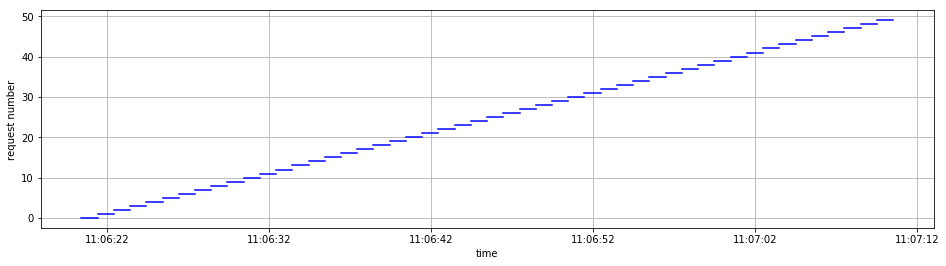

In [7]:
fig, ax = plt.subplots()
for l in log:
    ax.plot([datetime.utcfromtimestamp(l[1]), datetime.utcfromtimestamp(l[2])], 
            [l[0], l[0]], 
            color = 'blue')
ax.set_xlabel('time')
ax.set_ylabel('request number')
ax.grid(True)
fig.set_figwidth(16)

## asyncio version

We had to add several changes to the `asyncio` version. First of all, we added a limit of 10 processes to be processed simultaneously by means of a semaphore. Additionally, we cannot use the `pause` function, since it does not execute asynchronously. Instead we use `asyncio.sleep()`. 

In [8]:
random.seed(0)

In [9]:
log = []

In [10]:
DELAY = 1
def simulate_request(number_chunks):
    semaphore = asyncio.Semaphore(number_chunks)
    @asyncio.coroutine
    def http_get(i):
        nonlocal semaphore
        with (yield from semaphore):
            start = time.time()
            yield from asyncio.sleep(DELAY)
            end = time.time()
        return [i, start, end, random.randint(100, 10001)]
    return http_get

In [11]:
def run_experiment(num_iter, num_chunks):
    http_client = simulate_request(num_chunks)
    tasks = [http_client(i) for i in range(num_iter)]
    response_size = 0
    for future in asyncio.as_completed(tasks):
        data = yield from future
        response_size = response_size + data[3]
        log.append([data[0], data[1], data[2]])
    return response_size

In [12]:
num_iter = 50
num_chunks = 10

# The nest_asyncio module has to be used in order to run asyncio from a notebook
# see: https://github.com/jupyter/notebook/issues/3397
nest_asyncio.apply()
loop = asyncio.get_event_loop()

start = time.time()
result = loop.run_until_complete(run_experiment(num_iter, num_chunks))
end = time.time()
print('Result: {}, Time: {}'.format(result, end - start))

Result: 266845, Time: 5.009572744369507


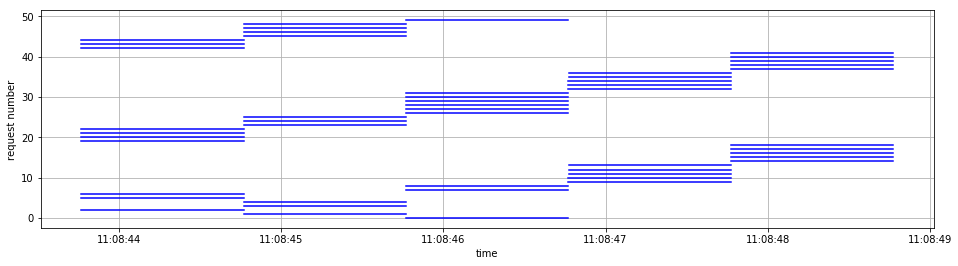

In [13]:
fig, ax = plt.subplots()
for l in log:
    ax.plot([datetime.utcfromtimestamp(l[1]), datetime.utcfromtimestamp(l[2])], 
            [l[0], l[0]], 
            color = 'blue')
ax.set_xlabel('time')
ax.set_ylabel('request number')
ax.grid(True)
fig.set_figwidth(16)